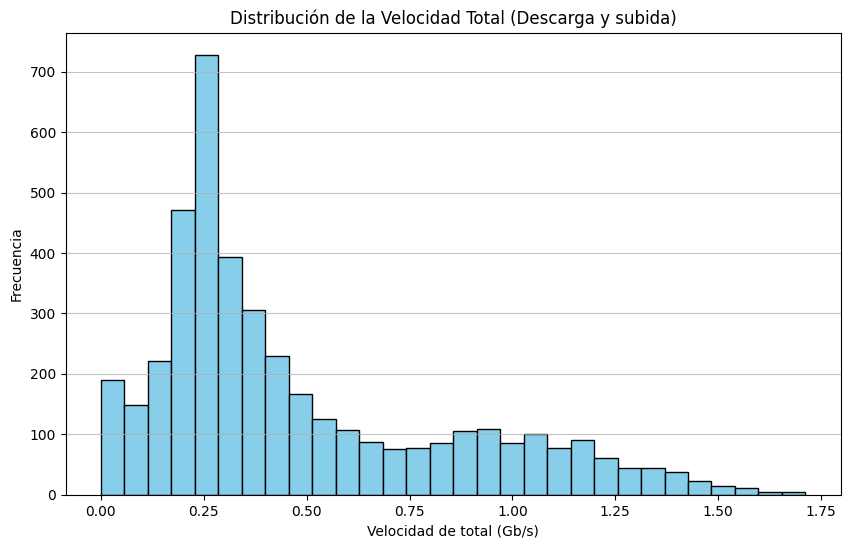

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class NET_LSTM:
    
    @classmethod
    def load_data(cls, file_path: str):
        """
        Load data from a csv file
        :param file_path: path to the csv file
        :return: a pandas dataframe
        """
        df = pd.read_csv(file_path)
        df = cls._clean_data(df)
        return df

    @staticmethod
    def _clean_data(df: pd.DataFrame):
        """
        Clean the data
        :param df: a pandas dataframe
        :return: a pandas dataframe
        """
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        return df

    @staticmethod
    def plot_hist_d(df: pd.DataFrame, column: str):
        """
        Plot a histogram 
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        if column == 'total_b/s':
            df['download_gb_s'] = df[column] / (10**9)  # Convert to Gb/s
            df['total_gb_s'] = df['total_b/s'] / (10**9)  # Convert to Gb/s
            df['time'] = pd.to_datetime(df['time'])  # Convert to datetime
            plt.figure(figsize=(10, 6))
            plt.hist(
                df['total_gb_s'],
                bins=30, color='skyblue',
                edgecolor='black'
            )
            plt.title('Distribución de la Velocidad Total (Descarga y subida)')
            plt.xlabel('Velocidad de total (Gb/s)')
            plt.ylabel('Frecuencia')
            plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the data
        :param df: a pandas dataframe
        :return: a pandas dataframe
        """
        # copilot
        # scaler = MinMaxScaler()
        # df_scaled = pd.DataFrame(
        #     scaler.fit_transform(df),
        #     columns=df.columns
        # )
        # return df_scaled
        
        # Select the features to normalize
        features = df['total_gb_s'].values.reshape(-1, 1)
        
        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_features = scaler.fit_transform(features)
        return scaled_features
        
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        # copilot
        # X, y = [], []
        # for i in range(len(df)):
        #     end_ix = i + n_steps
        #     if end_ix > len(df) - 1:
        #         break
        #     seq_x, seq_y = df[i:end_ix], df[end_ix]
        #     X.append(seq_x)
        #     y.append(seq_y)
        # return np.array(X), np.array(y)

        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
df = NET_LSTM.load_data('./outup/usage_over_time.csv')
NET_LSTM.plot_hist_d(df, 'total_b/s')  # Plot histogram

In [2]:
df.index = df['time']
df.head()

,time,download_b/s,total_b/s,download_gb_s,total_gb_s
time,,,,,
2022-02-01 00:00:00+00:00,2022-02-01 00:00:00+00:00,0.000000e+00,0.000000e+00,0.000000,0.000000
2022-02-02 18:00:00+00:00,2022-02-02 18:00:00+00:00,0.000000e+00,0.000000e+00,0.000000,0.000000
2022-02-02 22:00:00+00:00,2022-02-02 22:00:00+00:00,2.159972e+08,4.335945e+08,0.433595,0.433595
2022-02-03 02:00:00+00:00,2022-02-03 02:00:00+00:00,1.040372e+08,2.080813e+08,0.208081,0.208081
2022-02-03 06:00:00+00:00,2022-02-03 06:00:00+00:00,1.688578e+08,3.405690e+08,0.340569,0.340569


In [3]:
required_cols = ['download_gb_s', 'total_gb_s']
df = df[required_cols]
df.head()

,download_gb_s,total_gb_s
time,,
2022-02-01 00:00:00+00:00,0.000000,0.000000
2022-02-02 18:00:00+00:00,0.000000,0.000000
2022-02-02 22:00:00+00:00,0.433595,0.433595
2022-02-03 02:00:00+00:00,0.208081,0.208081
2022-02-03 06:00:00+00:00,0.340569,0.340569


In [4]:
df.isna().sum()
df = df.ffill()  # Fill missing values

In [5]:
df.head()

,download_gb_s,total_gb_s
time,,
2022-02-01 00:00:00+00:00,0.000000,0.000000
2022-02-02 18:00:00+00:00,0.000000,0.000000
2022-02-02 22:00:00+00:00,0.433595,0.433595
2022-02-03 02:00:00+00:00,0.208081,0.208081
2022-02-03 06:00:00+00:00,0.340569,0.340569


In [6]:
scaled_features = NET_LSTM.scale_data(df)  # Scale the data
n_steps = 18  # Number of time steps based on 3 days
X, y = NET_LSTM.create_sequences(scaled_features, n_steps) # Create sequences (Divide the data into input and target)

train_size = int(len(X) * 0.7)  # 70% train, 20% validation, 10% test
val_size = int(len(X) * 0.2)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

In [7]:
# Build the model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_steps, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\fabia\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Build the model
model = Sequential([
    Input(shape=input_shape=(n_steps, 1)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

SyntaxError: invalid syntax (<ipython-input-8-072778290a0a>, line 3)

In [9]:
# Build the model
model = Sequential([
    Input(shape=(n_steps, 1)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

NameError: name 'Input' is not defined

In [10]:
# Build the model
model = Sequential([
    Input(shape=(n_steps, 1)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

NameError: name 'Input' is not defined

In [11]:
from tensorflow.keras.layers import Input

In [12]:
# Build the model
model = Sequential([
    Input(shape=(n_steps, 1)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 18, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

In [14]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    # mode='min'
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [15]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
    # mode='min'
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [16]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [17]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    './best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=./best_model.h5

In [18]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    '/best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/best_model.h5

In [19]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
    # mode='min'
)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [20]:
# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [21]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0519 - val_loss: 0.0580
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0377 - val_loss: 0.0578
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0368 - val_loss: 0.0576
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0353 - val_loss: 0.0534
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0345 - val_loss: 0.0458
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0319 - val_loss: 0.0431
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0300 - val_loss: 0.0411
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0295 - val_loss: 0.0395
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0267 - val_loss: 0.0402
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0266 - val_loss: 0.0382
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0246 - val_loss: 0.0350
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0

In [22]:
)

SyntaxError: unmatched ')' (<ipython-input-22-a35077a93b18>, line 1)

In [23]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

NameError: name 'ReduceLROnPlateau' is not defined